# Preprocessing

For now we need just pandas for parsing dataset and transformers for BERT

In [8]:
# !conda update nbformat -y #AWS related package
!pip install transformers
import pandas as pd
from transformers import *
import numpy as np
import torch
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


Read excel file, skip headers and 1st row with column nasmes

PS : Small hack with deleting biggest files from dataset. Gonna be fixed after obtaining bigger resources

In [0]:
df= pd.read_excel('dataset.xlsx', header=None, skiprows=1)
# df.drop(df[df[4].map(len) > 250 ].index, inplace=True)
# df.reset_index()

For our smaller version of dataset just take two features that we are interested in, namely T PL and GOLD<T,H>

In [0]:
dataset = df[[4, 5]]

In [11]:
dataset.head

<bound method NDFrame.head of                                                       4  5
0     Ja na to, że mam klasówkę, że zawalę biologię ...  N
1            Ani że na progu stanął właśnie Romanyczko.  ?
2                  Potem, że się przywiezie Chińczyków.  N
3     Słabł coraz bardziej, czuł, że to kwestia zale...  N
4     Jednak ludzie bardzo ciężko chorzy, gdy już cz...  N
...                                                 ... ..
2591  Udało się ustalić, że obie dziewczynki mogą pr...  N
2592  Ustalono, że łączą go z niektórymi członkami g...  N
2593  Tu będą mogli zobaczyć, że Państwo Izrael ma k...  E
2594  Oczywiście, że można kochać, jeśli zobaczy się...  N
2595  Oczywiście, że można kochać, jeśli zobaczy się...  N

[2596 rows x 2 columns]>

Graphical representation of dataset

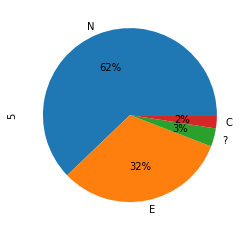

In [12]:
dataset[5].value_counts().plot(kind='pie', autopct='%1.0f%%')

Change labels of ECN for numeric values

In [0]:
labels = {'E':0,'C':1,'N':2,'?':3}

for idx, row in dataset.iterrows():
    row[5] = labels[row[5]]

In [14]:
dataset

,4,5
0,"Ja na to, że mam klasówkę, że zawalę biologię ...",2
1,Ani że na progu stanął właśnie Romanyczko.,3
2,"Potem, że się przywiezie Chińczyków.",2
3,"Słabł coraz bardziej, czuł, że to kwestia zale...",2
4,"Jednak ludzie bardzo ciężko chorzy, gdy już cz...",2
...,...,...
2591,"Udało się ustalić, że obie dziewczynki mogą pr...",2
2592,"Ustalono, że łączą go z niektórymi członkami g...",2
2593,"Tu będą mogli zobaczyć, że Państwo Izrael ma k...",0
2594,"Oczywiście, że można kochać, jeśli zobaczy się...",2


In [15]:
max_len = 0
m_idx = 0
for idx,row in dataset.iterrows():
    l = len(row[4])
    if l > max_len:
        max_len = l
        m_idx = idx
print(m_idx)

360


In [16]:
print(dataset[4][m_idx])

Ci z koalicji rządzącej, ci posłowie, którzy w trakcie posiedzenia sejmowej Komisji Polityki Gospodarczej, Budżetu i Finansów z uporem, myślę, godnym lepszej sprawy, bronili faktu, aby rząd łącznie z budżetem - zapowiadam, łącznie z budżetem, bo mamy świadomość, że nie było i nie ma czasu na to, żeby wcześniej rozpatrywać założenia, a potem przedkładać budżet - przedłożył założenia polityki społeczno-gospodarczej, jako dokumentu ujmującego tę politykę w dłuższym czasie, posłowie, którzy nie dopuścili do takiego rozstrzygnięcia - przypominam, tylko jednym głosem - źle służą również rządowi.


In [17]:
!pip install sklearn
from sklearn.model_selection import train_test_split

# Polbert

Here we import pretrained version of Bert for Polish language

In [18]:
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, "dkleczek/bert-base-polish-uncased-v1")

model = model_class.from_pretrained(pretrained_weights)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

## Tokenization

Tokenize every sentence from our dataset

In [0]:
tokenized = dataset[4].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [20]:
tokenized.values

array([list([2, 2055, 1898, 1907, 16, 2095, 2040, 15701, 1889, 3118, 16, 2095, 32091, 1014, 12071, 1014, 51, 1893, 15887, 1012, 1906, 27508, 2165, 4785, 18, 4]),
       list([2, 2937, 2095, 1898, 26468, 40126, 1019, 29480, 6977, 1013, 7150, 18, 4]),
       list([2, 3006, 16, 2095, 2243, 11319, 2713, 11007, 8572, 1889, 18, 4]),
       ...,
       list([2, 2030, 40221, 4949, 38584, 16, 2095, 2013, 2803, 12250, 1994, 26825, 2437, 48721, 16, 2030, 14229, 2114, 2808, 21694, 40575, 4955, 52867, 9417, 16, 2030, 8822, 1948, 2243, 24391, 3117, 4955, 52867, 1014, 27972, 16, 2030, 48570, 41886, 2243, 51, 5245, 50930, 36755, 50719, 15956, 23652, 2054, 18, 4]),
       list([2, 31040, 16, 2095, 29801, 6289, 1015, 16, 10865, 3403, 2243, 16, 2095, 2259, 16879, 1015, 1893, 40065, 1923, 2243, 68, 4109, 16, 2095, 2499, 3089, 1906, 3115, 3410, 18, 4]),
       list([2, 31040, 16, 2095, 29801, 6289, 1015, 16, 10865, 3403, 2243, 16, 2095, 2259, 16879, 1015, 1893, 40065, 1923, 2243, 68, 4109, 16, 2095, 2499, 

## Padding

We need to have input of the same lenght in order to feed BERT once (we will get performance speed). This will be some simple python string manipulations

In [0]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [22]:
max_len

146

Maybe we can consider shortening some sentences here

In [0]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [24]:
padded

array([[    2,  2055,  1898, ...,     0,     0,     0],
       [    2,  2937,  2095, ...,     0,     0,     0],
       [    2,  3006,    16, ...,     0,     0,     0],
       ...,
       [    2,  2030, 40221, ...,     0,     0,     0],
       [    2, 31040,    16, ...,     0,     0,     0],
       [    2, 31040,    16, ...,     0,     0,     0]])

In [25]:
np.array(padded).shape

(2596, 146)

## Computing embedding using BERT

Now we do create cube of 146(tokens per row) * 768 (hidden layers) * 2596

In [0]:
input_ids = torch.tensor(np.array(padded))

In [27]:
input_ids

tensor([[    2,  2055,  1898,  ...,     0,     0,     0],
        [    2,  2937,  2095,  ...,     0,     0,     0],
        [    2,  3006,    16,  ...,     0,     0,     0],
        ...,
        [    2,  2030, 40221,  ...,     0,     0,     0],
        [    2, 31040,    16,  ...,     0,     0,     0],
        [    2, 31040,    16,  ...,     0,     0,     0]])

In [28]:
input_ids.shape

torch.Size([2596, 146])

In [0]:
with torch.no_grad():
    last_hidden_states = model(input_ids)

We will extract two sets of embeddings. One for CSL only (2D array) and one for the whole cube

In [0]:
features = last_hidden_states[0][:,:,:].numpy()

In [31]:
cls_features = last_hidden_states[0][:,0,:].numpy()
cls_features

array([[ 0.2512698 ,  0.05621049,  0.528381  , ..., -0.16011806,
         0.09001451, -0.3821133 ],
       [ 0.4223248 ,  0.08961057,  0.49109307, ..., -0.20376708,
        -0.16196994, -0.53562206],
       [ 0.5043764 ,  0.0117968 ,  0.48297426, ..., -0.11081165,
        -0.0925103 , -0.424763  ],
       ...,
       [ 0.24305862, -0.14591734,  0.98260427, ...,  0.15874973,
         0.02587716, -0.27605462],
       [ 0.19790395, -0.05286026,  0.5464178 , ..., -0.07265604,
         0.03099428, -0.3345407 ],
       [ 0.19790395, -0.05286026,  0.5464178 , ..., -0.07265604,
         0.03099428, -0.3345407 ]], dtype=float32)

In [32]:
features.shape

(2596, 146, 768)

In [33]:
cls_features.shape

(2596, 768)

## Onehot encoding

In [34]:
y = np.array(dataset[5], dtype=np.int64)
y_labels = np.zeros((y.size, y.max()+1))
y_labels[np.arange(y.size),y] = 1
y_labels

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

## Feed Forward Neural Network
Creating Feed Forward Neural Network which will take as an input vector of embeddings and return one of semantic classes. Firstly we will do it for 2d CLS matrix

In [0]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as ds
import torch.nn.functional as F
import time

### Creating dataset

In [36]:
train_features, test_features, train_labels, test_labels = train_test_split(cls_features, y)
train_features[:10]

array([[ 0.45115012,  0.09015301,  0.55748165, ..., -0.11221309,
        -0.19982745, -0.1729647 ],
       [ 0.17683952,  0.2920767 ,  0.6517402 , ..., -0.40466264,
         0.09688655, -0.19988476],
       [ 0.13066062, -0.24874114,  0.80402017, ..., -0.0119098 ,
         0.17323563, -0.23938887],
       ...,
       [ 0.38235813, -0.02774972,  0.631201  , ..., -0.18055482,
        -0.17133313, -0.50075454],
       [ 0.21197279,  0.11593291,  0.29405218, ..., -0.10156006,
        -0.06168462, -0.2778198 ],
       [ 0.28741446,  0.08802292,  0.7256012 , ..., -0.23755473,
        -0.06756242, -0.27553165]], dtype=float32)

## Convert data to Torch tensor

In [0]:
train_features = torch.from_numpy(train_features)
test_features = torch.from_numpy(test_features)
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

In [38]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

torch.Size([1947, 768])
torch.Size([649, 768])
torch.Size([1947])
torch.Size([649])


In [39]:
batch_size = int(train_features.shape[0] / 50)
epochs = 20
batch_size

38

In [0]:
class FeedforwardNeuralNetModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(FeedforwardNeuralNetModel, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.output_zise = output_size
    self.fc1 = nn.Linear(self.input_size, self.hidden_size)
    self.fc2 = nn.Linear(hidden_size,hidden_size)
    self.fc3 = nn.Linear(self.hidden_size, output_size)


  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)
    return F.log_softmax(output, dim=0)

In [41]:
tokens = 1
input_dim = 768 * tokens
hidden_dim = 256
output_dim = len(labels)

input_dim

768

In [0]:
ffnn = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [0]:
criterion = nn.BCELoss(reduce=False)

In [44]:
print(ffnn)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [0]:
learning_rate = 0.05
optimizer = torch.optim.SGD(ffnn.parameters(), lr=learning_rate) 

In [0]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [56]:
train_losses = []

for epoch in range(0,101):
    
    ffnn.train(True)
    train_loss = 0 

    for x_batch, y_batch, batch in generate_batch_data(train_features, train_labels, batch_size):
        optimizer.zero_grad()
        y_pred = ffnn(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if epoch % 5 == 0:
      train_losses.append(train_loss/len(train_features))
      print(f"{epoch} / 100 | loss = {train_loss/len(train_features)}")






0 / 100 | loss = 0.007318192416573404
5 / 100 | loss = 0.006402662635216911
10 / 100 | loss = 0.006135901496480169
15 / 100 | loss = 0.00595215107608466
20 / 100 | loss = 0.005808561998235304
25 / 100 | loss = 0.005686614683455667
30 / 100 | loss = 0.005578865642019829
35 / 100 | loss = 0.0054798912989768725
40 / 100 | loss = 0.005389183220124943
45 / 100 | loss = 0.005307267993520209
50 / 100 | loss = 0.0052238118418161845
55 / 100 | loss = 0.005148852275589765
60 / 100 | loss = 0.005074909145350204
65 / 100 | loss = 0.005001380567022269
70 / 100 | loss = 0.004941045080369475
75 / 100 | loss = 0.004888663769656104
80 / 100 | loss = 0.004851547946639715
85 / 100 | loss = 0.0049002665278234415
90 / 100 | loss = 0.005234000415115033
95 / 100 | loss = 0.004771280283721582
100 / 100 | loss = 0.004671452732485995


Text(0.5, 1.0, 'Losses')

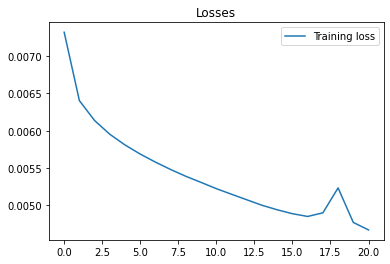

In [57]:
plt.plot(train_losses, label="Training loss")
plt.legend()
plt.title("Losses")

In [58]:
test_losses = []

for epoch in range(0,101):
    
    test_loss = 0 
    correct = 0
    ffnn.eval()

    for x_batch, y_batch, batch in generate_batch_data(test_features, test_labels, batch_size):
        y_pred = ffnn(x_batch)
        loss = criterion(y_pred, y_batch)
        pred = np.argmax(y_pred.data,axis=1)
        test_loss += loss.item()
        correct += pred.eq(y_batch.data).sum()

    if epoch % 5 == 0:
      test_losses.append(test_loss/len(test_features))

      print(f"{epoch} / 100 | loss = {test_loss/len(test_features)} | Accuracy = {100. * correct/len(test_features)}%")

0 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
5 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
10 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
15 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
20 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
25 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
30 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
35 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
40 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
45 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
50 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
55 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
60 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
65 / 100 | loss = 0.061203991733089616 | Accuracy = 65.48535919189453%
70 / 100